In [40]:
# загрузим необходимые библиотеки
%matplotlib inline
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Градиентный бустинг "в лоб"

In [28]:
# считаем данные и вектор ответов сразу запишем в отдельную переменную
features = pd.read_csv('features.csv', index_col='match_id')

X_train = features.drop(['duration', 'radiant_win',
               'tower_status_radiant', 'tower_status_dire',
               'barracks_status_radiant', 'barracks_status_dire'], axis=1)

y_train = features['radiant_win']

X_test = pd.read_csv('features_test.csv', index_col='match_id')

In [29]:
X_train.head(3)

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0


In [30]:
# выведем список признаков с пропусками и % пропусков
rows = len(X_train)
counts = X_train.describe().T['count']
counts_na = counts[counts < rows]
counts_na.sort_values().apply(lambda c: (rows - c) / rows)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_time               0.201100
first_blood_team               0.201100
first_blood_player1            0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
Name: count, dtype: float64

In [31]:
# вывести список можно и так:
features_count = dict(X_train.count())
features_count = sorted(features_count.items(), key=lambda x: x[1])
features_count[0:13]

[('first_blood_player2', 53243),
 ('radiant_flying_courier_time', 69751),
 ('dire_flying_courier_time', 71132),
 ('first_blood_time', 77677),
 ('first_blood_team', 77677),
 ('first_blood_player1', 77677),
 ('dire_bottle_time', 81087),
 ('radiant_bottle_time', 81539),
 ('radiant_first_ward_time', 95394),
 ('dire_first_ward_time', 95404),
 ('radiant_courier_time', 96538),
 ('dire_courier_time', 96554),
 ('start_time', 97230)]

In [32]:
# заполним пропуски нулями
X_train = X_train.fillna(0).astype(int)

### Обучение модели

In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=17)

In [10]:
%%time
scores = []
nums = [10, 20, 30, 50, 150, 250]

for n in nums:
    print("N_estimators =", n)
    model = GradientBoostingClassifier(n_estimators=n, random_state=17)
    model_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc', n_jobs=-1)
    print(model_scores)
    scores.append(np.mean(model_scores))

N_estimators = 10
[ 0.66074052  0.65980314  0.66760099  0.65683934  0.67369049]
N_estimators = 20
[ 0.67727801  0.67662887  0.68691047  0.67747497  0.68765006]
N_estimators = 30
[ 0.68577529  0.6844015   0.69439328  0.68581051  0.69384759]
N_estimators = 50
[ 0.69420342  0.69262095  0.70215968  0.69360977  0.70329114]
N_estimators = 150
[ 0.70871956  0.70551569  0.71565071  0.70659643  0.71564765]
N_estimators = 250
[ 0.71552632  0.71056913  0.72120316  0.71244505  0.72044006]
Wall time: 12min 4s


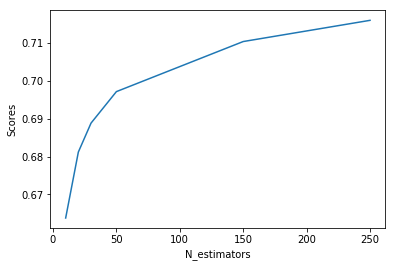

In [11]:
# посмотрим график зависимости качества модели от количества деревьев
plt.plot(nums, scores)
plt.xlabel('N_estimators')
plt.ylabel('Scores');

Качество еще достаточно плохое, потому что мы использовали абсолютно все признаки, никак их не обрабатывали и не проводили более тщательную кросс-валидацию. Но при этом при увеличении количества деревьев качество растет и близится к значению 0.72

Для достижения большего качества имеет смысл использовать более 30 деревьев. Для ускорения обучения можно использовать не всю выборку, а некоторое ее подмножество — оптимально брать соотношение 70/30. Также можно посмотреть как уменьшение глубины деревьев скажется на качестве модели.

# Логистическая регрессия

Напишем несколько функций, чтобы подбирать параметр регуляризации С и смотреть как новые изменения сказались на общем качестве модели

In [17]:
def plot_with_c(C_powers, scores):
    plt.plot(C_powers, scores)
    plt.xlabel('log(C)')
    plt.ylabel('scores');

def testing(X, y, C):
    model = LogisticRegression(C=C, n_jobs=-1, random_state=17)
    return cross_val_score(model, X, y, cv=kfold, scoring='roc_auc', n_jobs=-1)

# подбор параметра С
def test_model(X, y):
    scores = []
    st_scaler = StandardScaler()
    X_scale = st_scaler.fit_transform(X)
    C_powers = range(-5, 6)
    C_param = [10 ** i for i in C_powers]
    for C in C_param:
        model_scores = testing(X_scale, y, C)
        print("C =", C, 'Score =', model_scores.mean())
        scores.append(np.mean(model_scores))
        
    plot_with_c(C_powers, scores)
    max_score = max(scores)
    max_score_index = scores.index(max_score)
    
    return C_param[max_score_index], max_score

C = 1e-05 Score = 0.695067106046
C = 0.0001 Score = 0.71117516939
C = 0.001 Score = 0.716138077109
C = 0.01 Score = 0.716325473887
C = 0.1 Score = 0.716300459475
C = 1 Score = 0.716296996207
C = 10 Score = 0.716296816332
C = 100 Score = 0.716296765574
C = 1000 Score = 0.716296763457
C = 10000 Score = 0.71629675922
C = 100000 Score = 0.716296754985
Results:
 C = 0.01 
Best Score = 0.716325473887
Wall time: 2min 44s


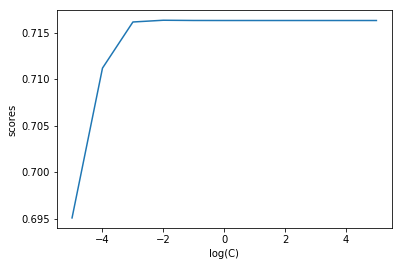

In [18]:
%%time
# самая простая модель, кроме маштабирования признаков больше ничего не применяем
C, max_score = test_model(X_train, y_train)
print('Results:\n C =', C, '\nBest Score =', max_score)

### Удалим категориальные признаки

C = 1e-05 Score = 0.695012983541
C = 0.0001 Score = 0.711177738364
C = 0.001 Score = 0.716174961155
C = 0.01 Score = 0.716366661529
C = 0.1 Score = 0.716341677251
C = 1 Score = 0.716337894115
C = 10 Score = 0.716337527765
C = 100 Score = 0.716337404883
C = 1000 Score = 0.716337364638
C = 10000 Score = 0.716337362523
C = 100000 Score = 0.716337360405
Results:
 C = 0.01 
Best Score = 0.716366661529
Wall time: 2min 40s


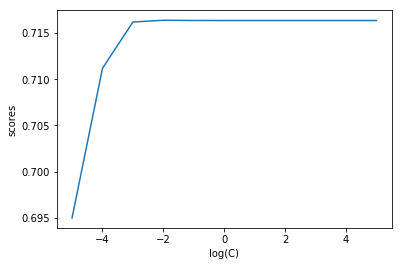

In [23]:
%%time

X_train.drop(['lobby_type'], axis=1)
for i in range(1, 6):
    X_train.drop(['r{}_hero'.format(i), 'd{}_hero'.format(i)], axis=1)

    
# проверим модель на выборке без категориальных признаков
C, max_score = test_model(X_train, y_train)
print('Results:\n C =', C, '\nBest Score =', max_score)

Качество и лучшее значение гиперпараметра С - никак не изменились. Значит наша модель смогла распознать этот шум.

### Добавим мешок слов для героев

In [35]:
# посмотрим сколько героев имеется
np.unique(X_train[['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero']]).max()

112

In [37]:
# ф-ция для мешка слов
def bag_of_heroes(X):
    X_pick = np.zeros((X.shape[0], 112))
    for i, match_id in enumerate(X.index):
        for p in range(5):
            X_pick[i, X.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, X.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
            
    return pd.DataFrame(X_pick, index=X.index)

In [41]:
X_heroes = bag_of_heroes(X_train)

C = 1e-05 Score = 0.714816557414
C = 0.0001 Score = 0.742683407776
C = 0.001 Score = 0.751504033108
C = 0.01 Score = 0.751821387716
C = 0.1 Score = 0.751785096439
C = 1 Score = 0.751779683992
C = 10 Score = 0.751779470458
C = 100 Score = 0.751779339049
C = 1000 Score = 0.751779296697
C = 10000 Score = 0.751779303054
C = 100000 Score = 0.751779305173
Results:
 C = 0.01 
Best Score = 0.751821387716
Wall time: 3min 41s


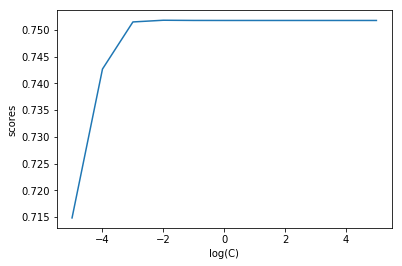

In [42]:
%%time
# соединим два датафрейма и проверим модель с новыми признаками
X_train_with_heroes = pd.concat([X_train, X_heroes], axis=1)

C, max_score = test_model(X_train_with_heroes, y_train)
print('Results:\n C =', C, '\nBest Score =', max_score)

При добавлении мешка слов - качество значительно выросло(на 0.04). Это объясняется тем, что id - не давали никакую информацию и были пустыми числами для модели. Но т.к. мы создали новые признаки на основе этих номеров - мы смогли по-другому их преподнести, а значит - модель их воспринимала совсем по-другому.